In [ ]:
import re
import json
import numpy as np
import pandas as pd
from copy import deepcopy
#Account Age
import time
from datetime import datetime

#SQL
import mysql.connector 
from mysql.connector import errorcode
import config
import json

import matplotlib.pyplot as plt

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

## Product Analysis 

1. look into trending products
2. Find average price of trending products 

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['Successful', 'sale', 'to', 'Sold', 'sold', 'an', 'Bought', 'a', 'from', 'purchased', 'some', 'cash', 'for', 'with', 'was', 'the', 'bought', 'it', 'is', 'Purchased', 'trade', 'Traded', 'great', 'new', 
 'shipping', 'received', 'my', 'of', 'supply', 'in', 'me', 'Confirmed', 'very', 'off', 'Great', 'broken', 'shipped',  
 'traded', 'as', 'I', 'set', 'parts', 'on', 'locally', 'you', 'but', 'Thanks', 'Thanks!', 'Thank', 'used', ']', '[', '(', ')', ' Local Cash', ' PayPal', '  Paypal', ' Local', ' local cash', '  PayPal', ' Paypal', ' Cash', ' Local cash', ' cash', ' paypal', '  Local Cash', 'Trades', 'PayPal', 'Local', 'Cash', 'Paypal', 'local', ' paypal', 'Verified', ' Steam Link'] )

In [ ]:
def text_process(mess):
    lemmatizer = WordNetLemmatizer()
    temp_list = []
    for product in title:
        product = product.split()
        if word not in stop_words:
            word = lemmatizer.lemmatize(word)
            temp_list.append(word)
            
    return temp_list

In [ ]:
def sql_to_df():
    cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        password = config.passwd,
        database = config.db_name
    )
    cur = cnx.cursor()
    cur.execute("""SELECT * FROM Submissions.submissions;""")
    df_sql = pd.DataFrame(cur.fetchall())
    df_sql.columns = [x[0] for x in cur.description]
    df_sql.drop('index', axis=1, inplace=True)
    cur.close()
    cnx.close()
    return df_sql

In [ ]:
df = sql_to_df()

In [ ]:
def clean_titles(df):
    titles = df['title'].values.tolist()
    
    separate_titles = []
    product_list = []
    final_product_list = []
    temp_string = ''
    for title in titles:
        new_string = re.sub(r'\[.*?\]', '', title)
        if ',' in new_string:
            separate_titles.append(new_string.split(','))
        elif '|' in new_string:
            new_string = new_string.replace('|', ',')
            separate_titles.append(new_string.split(','))
        else:
            separate_titles.append([new_string])
            
    
    for title in separate_titles:
        for product in title:
            product_list.append(product)
            

    lemmatizer = WordNetLemmatizer()
    for product in product_list: 
        product = product.split()
        for word in product:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word)
                temp_string += ' ' + word.lower()
        if temp_string != '':
            final_product_list.append(temp_string[1:])
        temp_string = ''
        
    return final_product_list
    

In [ ]:
def search_products(product_name): 
    cnx = mysql.connector.connect(
            host = config.host,
            user = config.user,
            password = config.passwd,
            database = config.db_name
        )
    cur = cnx.cursor()
    cur.execute(f"""SELECT * FROM Submissions.submissions
                   WHERE title LIKE '%{product_name}%';""")
    df_search = pd.DataFrame(cur.fetchall())
    df_search.columns = [x[0] for x in cur.description]
    df_search = df_search[['id', 'date', 'title', 'direction', 'text', 'link']]
    cur.close()
    cnx.close()
    
    return df_search

In [ ]:
search_results = search_products('2080 super')

## Title Analysis 

Will look into common words and numbers in titles to help determine popular products.  Additionally These commons numbers and words can be used to find products in the text of posts.  

### Common Numbers

In [ ]:
common_numbers = []
for index, row in df.iterrows():
#         print(row['title'], row['text'])
    pk = row['id']
    body_text = row['text']
    title = row['title']

    numbers = re.findall(r'([0-9]{2,4})', title)
    if numbers != []:
        common_numbers.append(numbers)

In [ ]:
num_freq = {}

for nums in common_numbers: 
    for number in nums: 
        if number not in num_freq: 
            num_freq[number] = 1
        else:
            num_freq[number] += 1

In [ ]:
dictnums = dict((k, v) for k, v in num_freq.items() if v >= 20)

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8))
plt.bar(range(len(dictnums)), list(dictnums.values()), align='center')
plt.xticks(range(len(dictnums)), list(dictnums.keys()), rotation='vertical');

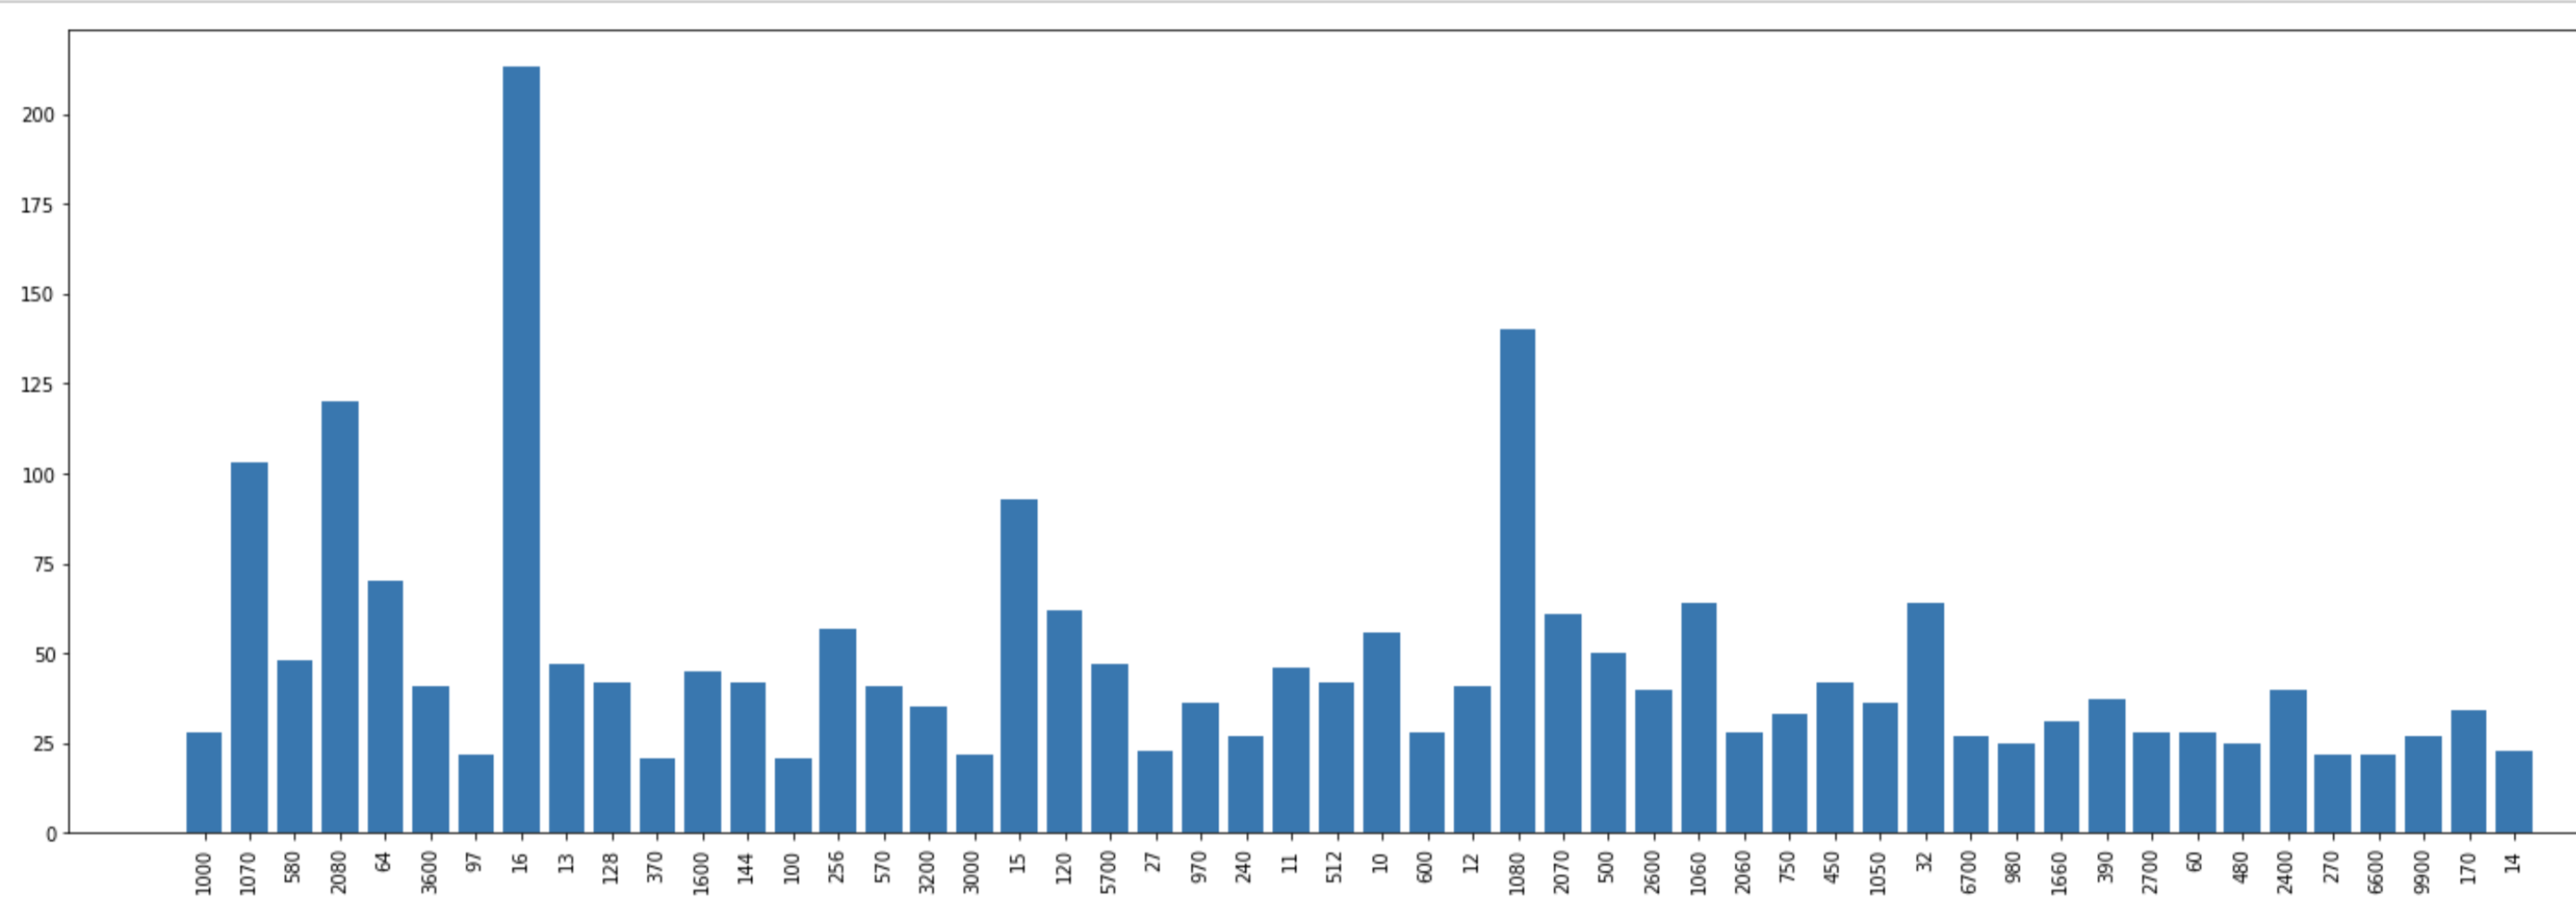

## Product Analysis
#### GTX 1080 TI

In [ ]:
def amt_of_products_selling(title):
    have = title.find('[H]')
    want = title.find('[W]')
    products_title = title[have+3:want]
    products_title = products_title.replace('|', ',')
    if products_title.count(',') == 0:
        return 1
    else:
        return products_title.count(',') + 1

In [ ]:
def amt_of_products_buying(title):
    want = title.find('[W]')
    products_title = title[want+3:]
    products_title = products_title.replace('|', ',')
    if products_title.count(',') == 0:
        return 1
    else:
        return products_title.count(',') + 1

In [ ]:
def text_to_price(series):
    body = series.replace('1080', '')
    price = re.findall(r'[\$\£\€](\d+(?:\.\d{1,2})?)', body) or re.findall(r'[0-9]+', body)
    price_list = close_numbers_gtx1080ti(price)
    if price_list != []:
        return round(mean(price_list), 2)
    else:
        return

In [ ]:
def close_numbers_gtx1080ti(price_list): 
    c = 0 
    final_price = []
    for price in price_list: 
        price = float(price)
        if price>= 400 and price<= 2000: 
            final_price.append(price) 
    return final_price 

In [ ]:
def product_analysis(product_name):
    product_search = search_products(product_name)
    selling = product_search[product_search['direction'] == 'SELLING']
    buying = product_search[product_search['direction'] == 'BUYING']
    
    selling['product_num'] = selling['title'].apply(amt_of_products_selling)
    buying['product_num'] = buying['title'].apply(amt_of_products_buying)
    
    buying1 = buying[buying['product_num'] == 1]
    selling1 = selling[selling['product_num'] == 1]
    
    selling1['price'] = selling['text'].apply(text_to_price)
    buying1['price'] = buying1['text'].apply(text_to_price)
    
    return selling1.dropna(), buying1.dropna()

## Product Analysis of Submissions selling 1 Proudct

In [ ]:
# Takes in DF and narrows to submissions where only 1 item is being sold.  This makes it a lot easier to identify the 
# price that the product was being sold for.  Then it creates a dataframe with the name of the Item, PK and Price 


def product_selling_price(df): 
    df_selling = df[df['direction'] == 'SELLING']
    df_selling['num_products'] = df_selling['title'].apply(amt_of_products_selling)
    df_selling_1 = df_selling[df_selling['num_products'] == 1]
    product_price_list = []
    product_list = []

    for index, row in df_selling_1.iterrows():
    #         print(row['title'], row['text'])
        pk = row['id']
        body_text = row['text']
        prod_in_title = products_in_title_selling(row['title'])
        product_list.append(prod_in_title)
        price = re.search(r'[\$\£\€](\d+(?:\.\d{1,2})?)', body_text)

        if price: 
            price = float(price.group()[1:])
            if price >= 2:
                product_price_list.append([pk, prod_in_title[0], price])
        else:
            continue

    df_price = pd.DataFrame(product_price_list, columns=['id', 'product', 'price'])
    return df_price

In [ ]:
product_prices = product_selling_price(df)

In [ ]:
product_prices

![product_prices.png](attachment:images/product_prices.png)

### Product Analysis 2

Pull price information for products as submissions come in.  Overtime this will be a more efficient way to collect data rather then querying after data collect 

In [ ]:
# returns Dataframe of all submissions with only one product and their price 
# next step is to be able to determine prices for submissions with more than one product 

product_price_list = []
product_list = []

for index, row in df_selling_1.iterrows():
#         print(row['title'], row['text'])
    pk = row['id']
    body_text = row['text']
    prod_in_title = products_in_title_selling(row['title'])
    product_list.append(prod_in_title)
    price = re.search(r'[\$\£\€](\d+(?:\.\d{1,2})?)', body_text)
    if price: 
        product_price_list.append([pk, prod_in_title[0], float(price.group()[1:])])
    else:
        continue
        
df_price = pd.DataFrame(product_price_list, columns=['id', 'product', 'price'])